In [43]:
import numpy as np
import pandas as pd
from shutil import copyfile
from astropy.cosmology import Planck13 as cosmo
import fsps
from matplotlib import gridspec
from astropy.io import fits
from astropy import wcs
from astropy.table import Table
from sim_engine import Scale_model
from spec_tools import Source_present, Oldest_galaxy, Sig_int, Smooth
from spec_stats import Smooth, Highest_density_region
from spec_id import *
from spec_stats import Highest_density_region, Linear_fit
from spec_exam import Gen_spec
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from sim_engine import forward_model_grism

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [57]:
med,le,he = np.zeros([3,10])
for i in range(10):
    x,px = np.load('../data/posteriors/GND_21156_tabfit_Pm{0}.npy'.format(i+1))
    med[i],le[i],he[i] = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Pa.npy')
a,ale,ahe = Highest_density_region(px,x)

x,px = np.load('../data/posteriors/GND_21156_tabfit_Plm.npy')
m,mle,mhe = Highest_density_region(px,x)

time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

In [58]:
T=[0]
M=[0]
IMB = []
for i in range(len(time)//2):
    mass = sfr[i*2+1] * (time[i*2+1] - time[i*2])
    M.append(M[i] + mass)
    IMB.append(mass)
    T.append(time[i*2+1])

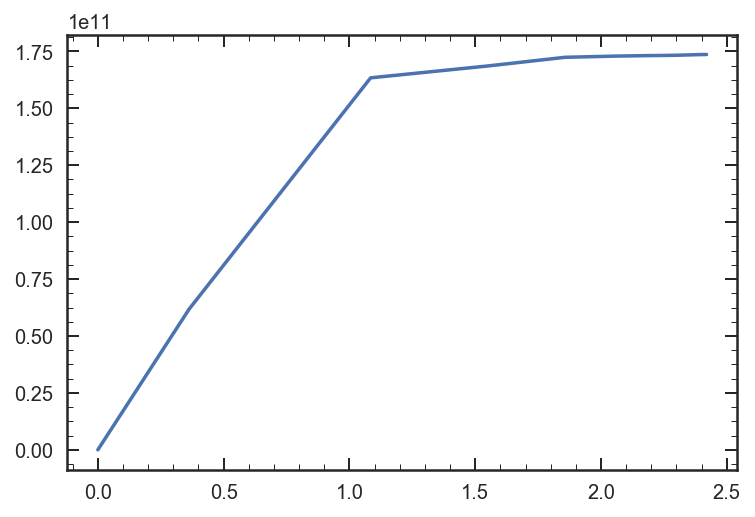

In [59]:
plt.plot(T,M / M[-1] * 10**m)

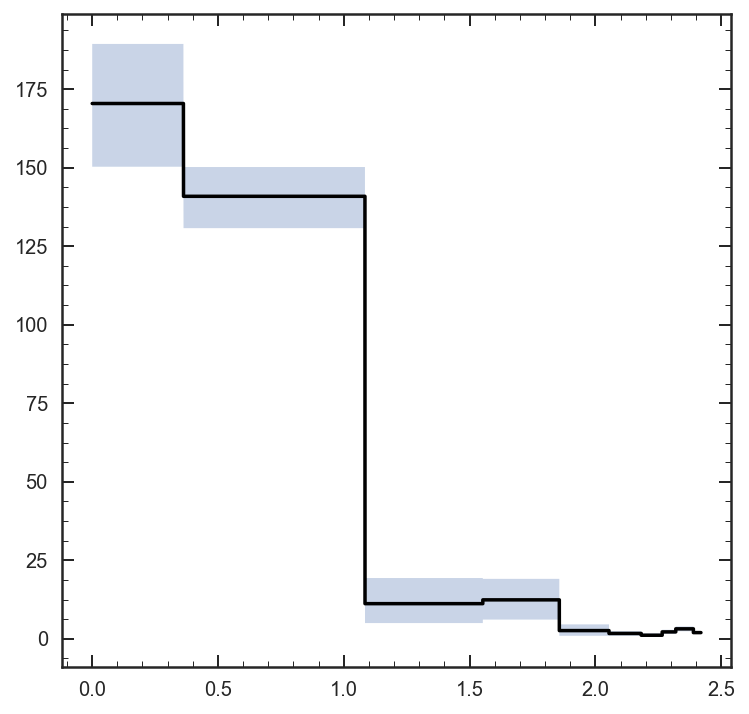

In [62]:
plt.figure(figsize=[6,6])
plt.plot(time,sfr/ M[-1] * 10**m / 1E9,'k')
# plt.plot(time,sfr_l,'k')
# plt.plot(time,sfr_h,'k')
plt.fill_between(time,sfr_l/ M[-1] * 10**m / 1E9, sfr_h/ M[-1] * 10**m / 1E9, alpha = 0.3)


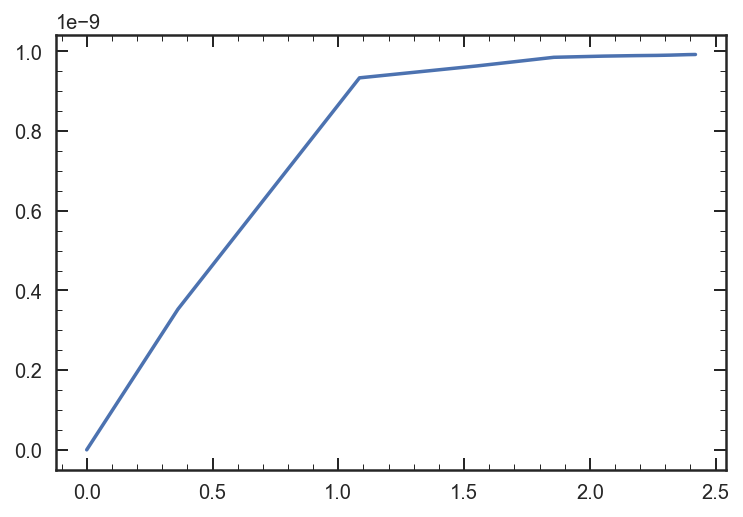

In [53]:
plt.plot(T,M)

In [147]:
rshifts = np.arange(0,14,0.01)
age_at_z = cosmo.age(rshifts).value
age_to_z = interp1d(age_at_z, rshifts)

class Rescale_sfh(object):
    def __init__(self, field, galaxy):
    
        med,le,he = np.zeros([3,10])
        for i in range(10):
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(field, galaxy, i+1))
            med[i],le[i],he[i] = Highest_density_region(px,x)

        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(field, galaxy))
        self.a,ale,ahe = Highest_density_region(px,x)

        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plm.npy'.format(field, galaxy))
        self.m,mle,mhe = Highest_density_region(px,x)

        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(field, galaxy))
        self.z,zle,zhe = Highest_density_region(px,x)
        
        self.time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
        self.time, sfr_l, tmax = convert_sfh(get_agebins(a), med - le, maxage = a*1E9)
        self.time, sfr_h, tmax = convert_sfh(get_agebins(a), med + he, maxage = a*1E9)

        self.T=[0]
        self.M=[0]
        for i in range(len(time)//2):
            mass = sfr[i*2+1] * (self.time[i*2+1] - self.time[i*2])
            self.M.append(M[i] + mass)
            self.T.append(time[i*2+1])

        self.t_50 = interp1d(self.M/ self.M[-1], self.T)(0.5)
        
        
        self.sfr = sfr/ self.M[-1] * 10**self.m / 1E9
        self.sfr_l = sfr_l/ self.M[-1] * 10**self.m / 1E9
        self.sfr_h = sfr_h/ self.M[-1] * 10**self.m / 1E9
        self.M = self.M/ self.M[-1] * 10**self.m

        
        for i in range(len(self.sfr)):
            if self.sfr[i] < max(self.sfr) * 0.1:
                self.t_q = self.time[i]
                break
                
        self.ssfr = self.sfr[-1] / 10**self.m
        
        self.z_q = age_to_z(Oldest_galaxy(self.z) - self.a + self.t_q)
        self.z_50 = age_to_z(Oldest_galaxy(self.z) - self.a + self.t_50)
        
        
        
        

In [148]:
sfh = Rescale_sfh('GND', 21156)

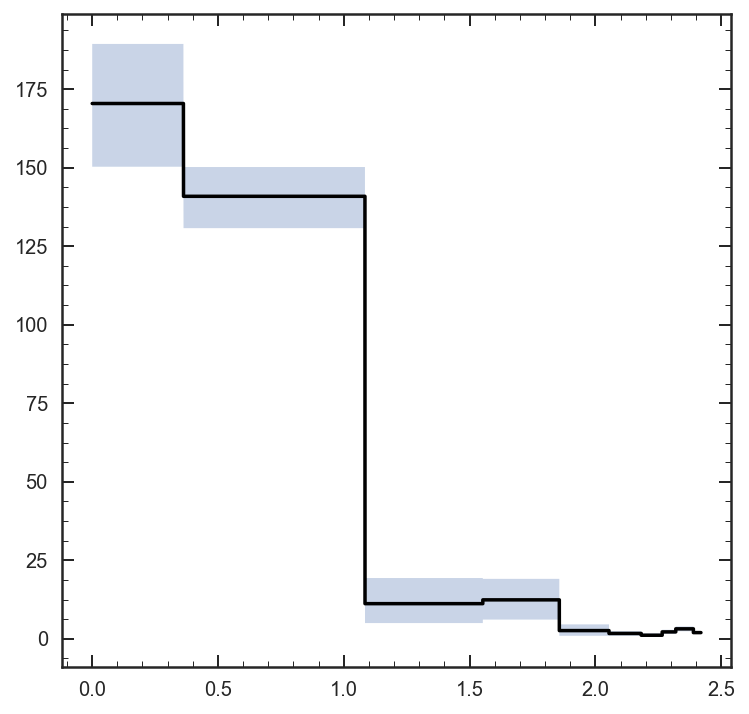

In [97]:
plt.figure(figsize=[6,6])
plt.plot(time, sfh.sfr, 'k')
plt.fill_between(time, sfh.sfr_l, sfh.sfr_h, alpha = 0.3)

In [143]:
print(sfh.t_q, sfh.ssfr, sfh.t_50)

1.0844845201742475 1.1450056957324239e-11 0.5405224080391596


In [149]:
print(sfh.a, sfh.a - sfh.t_q, sfh.a - sfh.t_50)

2.41963263957566 1.3351481194014125 1.8791102315365005


In [150]:
print(sfh.z, sfh.z_q, sfh.z_50)

1.253670609007323 1.8036117583728595 2.133735106126147


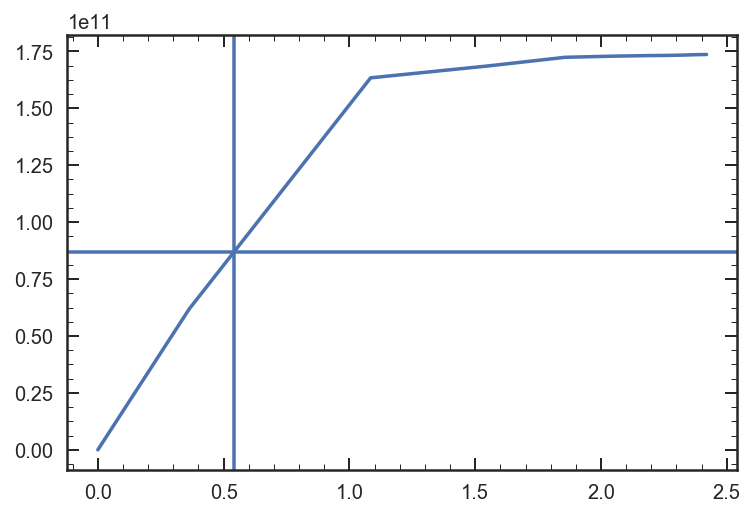

In [145]:
plt.plot(sfh.T,sfh.M)
plt.axvline(sfh.t_50)
plt.axhline(0.5 * sfh.M[-1])

In [85]:
interp1d(sfh.M/ sfh.M[-1], sfh.T)(0.5)

array(0.54052241)

In [2]:
plt.figure(figsize = [10,10])
for i in range(len(fld)):
    med = np.zeros(10)
    for ii in range(10):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pm{2}.npy'.format(fld[i], ids[i], ii+1))
        med[ii] = x[px == px.max()][0]

    x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pa.npy'.format(fld[i], ids[i]))
    a = x[px == px.max()][0]

    time, sfr, tmax = convert_sfh(get_agebins(a), med, maxage = a*1E9)
    
    plt.plot(time,sfr)
plt.xlabel('t$_{star-formation}$ (Gyr)', fontsize=20)
plt.ylabel('SFR', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.savefig('../plots/all_sfr.png' ,bbox_inches = 'tight')


NameError: name 'fld' is not defined

<Figure size 720x720 with 0 Axes>

# get size

In [3]:
goodss_rad = Table.read('/Users/vestrada/Downloads/allfields/goodss/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
goodsn_rad = Table.read('/Users/vestrada/Downloads/allfields/goodsn/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodss_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodss_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodss_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodss_3dhst.v4.1.cats/Fast/goodss_3dhst.v4.1.fout',format='ascii').to_pandas()
# goodsn_rad = Table.read('/Users/Vince.ec/Clear_data/galaxy_meas/goodsn_3dhst.v4.1_f125w.galfit',format='ascii').to_pandas()
# goodsn_fast = Table.read('/Users/Vince.ec/catalogs_for_CLEAR/goodsn_3dhst.v4.1.cats/Fast/goodsn_3dhst.v4.1.fout',format='ascii').to_pandas()


In [4]:
select = pd.read_pickle('../spec_files/section.pkl')

In [5]:
Reff = np.zeros(len(select))
Rpc = np.zeros(len(select))
lm, lml, lmh = np.zeros([3,len(select)])
rs, rsl, rsh =  np.zeros([3,len(select)])
lwa, lwal, lwah =  np.zeros([3,len(select)])
IDX = np.zeros(len(select))


for i in select.index:
    if select.AGN[i] != 'AGN' and select.use[i] == True:
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(select.field[i],select.id[i]))
        rs[i], rsl[i], rsh[i] = Highest_density_region(px,x)
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plm.npy'.format(select.field[i],select.id[i]))
        lm[i], lml[i], lmh[i] = Highest_density_region(px,x)
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(select.field[i],select.id[i]))
        lwa[i], lwal[i], lwah[i] = Highest_density_region(px,x)
    
        IDX[i] = i
        
        if select.field[i][1] == 'S':
            r = goodss_rad.re[goodss_rad.NUMBER == select.id[i]].values * np.sqrt(goodss_rad.q[goodss_rad.NUMBER == select.id[i]].values)
            Reff[i]= r[0] 
            Rpc[i]= r[0] / cosmo.arcsec_per_kpc_proper(rs[i]).value
        if select.field[i][1] == 'N':
            r = goodsn_rad.re[goodsn_rad.NUMBER == select.id[i]].values * np.sqrt(goodsn_rad.q[goodsn_rad.NUMBER == select.id[i]].values)
            Reff[i]= r[0] 
            Rpc[i]= r[0] / cosmo.arcsec_per_kpc_proper(rs[i]).value

    

In [6]:
Rpc = Rpc[Reff > 0]
lm = lm[Reff > 0]
lml = lml[Reff > 0]
lmh = lmh[Reff > 0]
rs = rs[Reff > 0]
rsl = rsl[Reff > 0]
rsh =  rsh[Reff > 0]
lwa = lwa[Reff > 0]
lwal = lwal[Reff > 0]
lwah = lwah[Reff > 0]
IDX = IDX[Reff > 0]
Reff = Reff[Reff > 0]


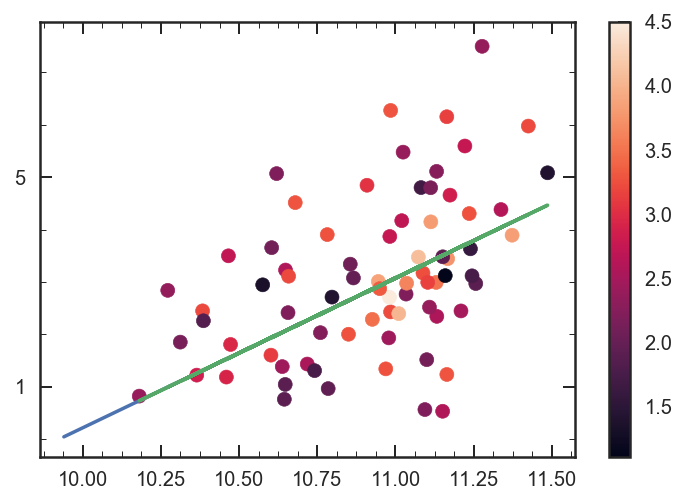

In [7]:
m = (np.log10(3.45) - np.log10(0.68)) / (11.35 -  9.94)

plt.scatter(lm,np.log10(Rpc), c = lwa)
plt.yticks([np.log10(1),np.log10(5)],[1,5])
plt.plot([9.94,11.35], np.log10([0.68, 3.45]))
plt.plot(lm, m*lm - 5.14)
plt.colorbar()

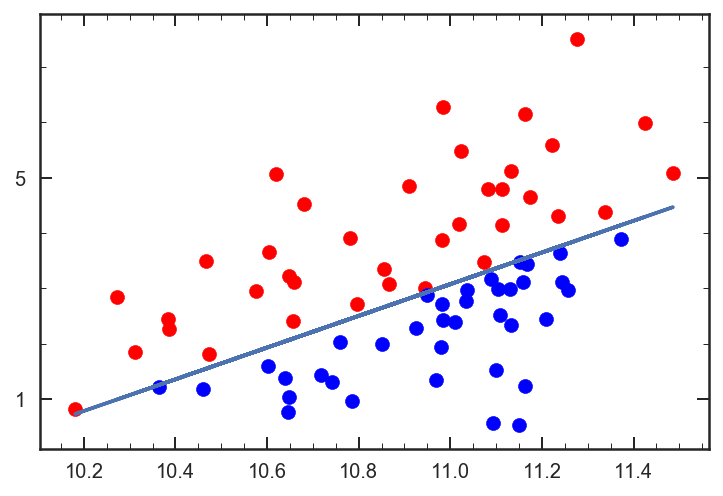

In [8]:
# plt.scatter(lmass,np.log10(Rpc), c = lwa)
plt.yticks([np.log10(1),np.log10(5)],[1,5])
for i in range(len(lm)):
    if np.log10(Rpc[i]) > m*lm[i] - 5.14:
        plt.scatter(lm[i],np.log10(Rpc[i]), color = 'r')
    else:
        plt.scatter(lm[i],np.log10(Rpc[i]), color = 'b')
        


plt.plot(lm, m*lm - 5.14)
# plt.colorbar()

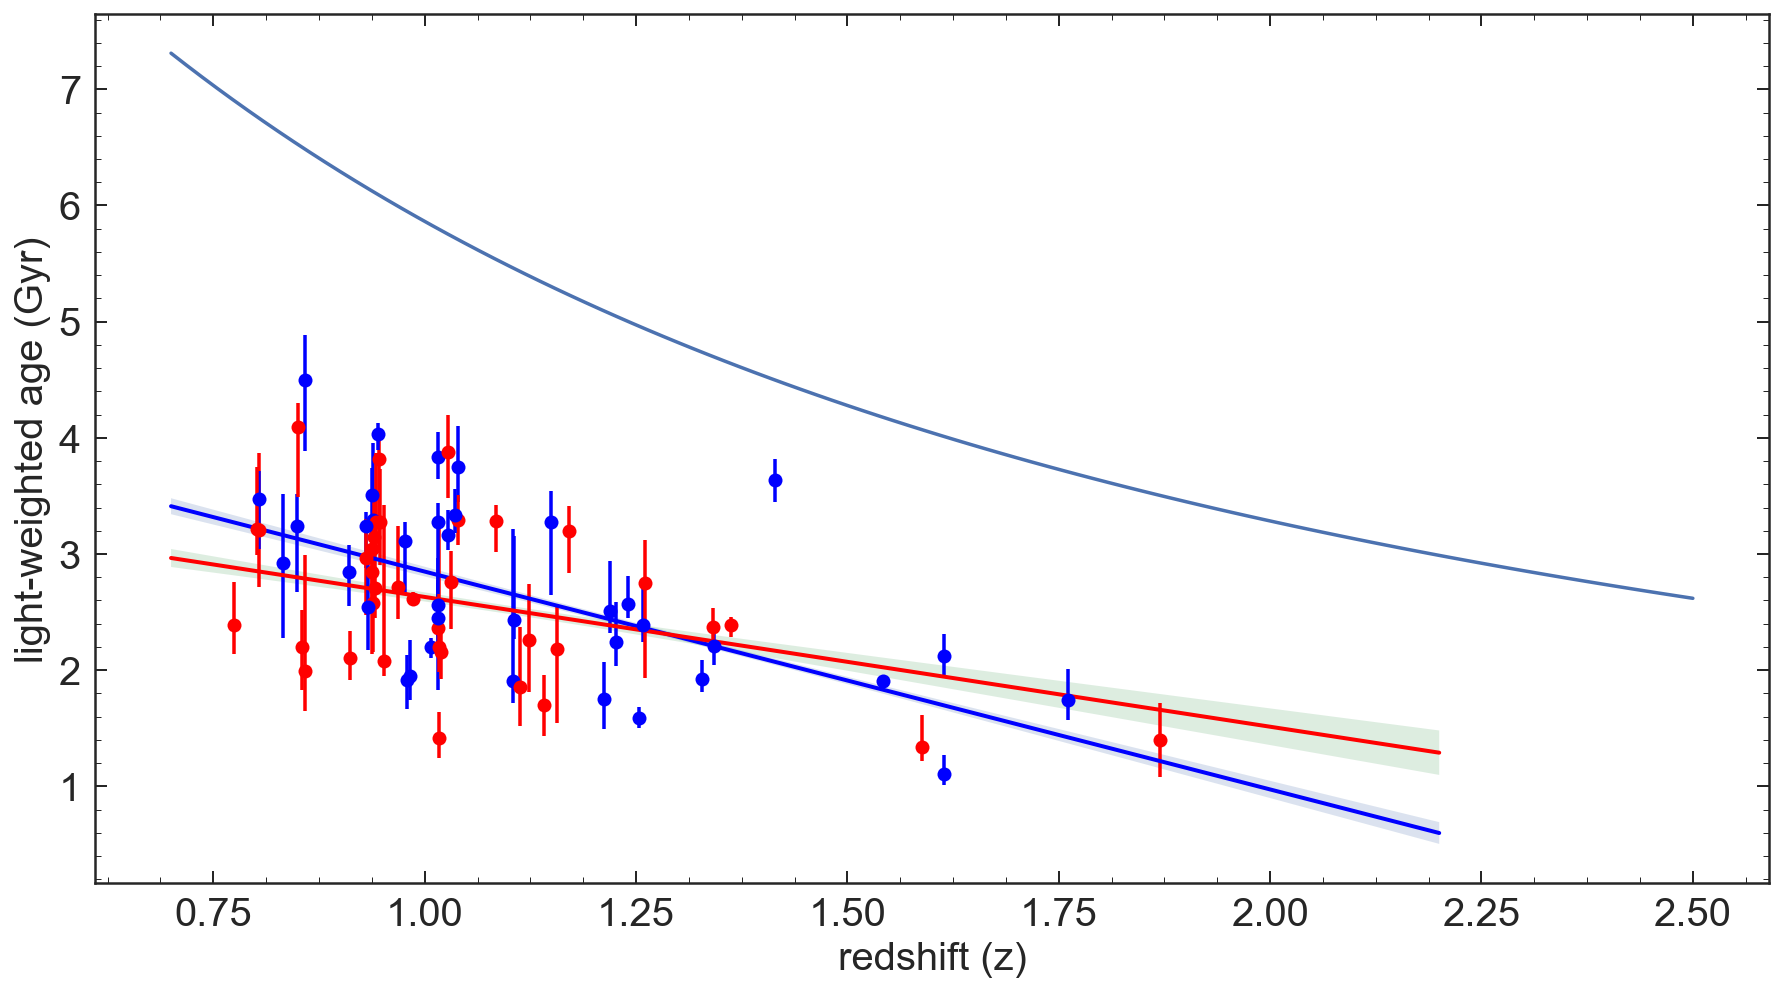

In [9]:
IDC = []
IDE = []

IDXC = []
IDXE = []

z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

for i in range(len(lm)):
    if np.log10(Rpc[i]) > m*lm[i] - 5.14:
        IDE.append(i)
        IDXE.append(IDX[i])
        
        plt.errorbar(rs[i],lwa[i], yerr=[[lwal[i]],[lwah[i]]], fmt='o', color = 'r')
    else:
        IDC.append(i)
        IDXC.append(IDX[i])
        
        plt.errorbar(rs[i],lwa[i], yerr=[[lwal[i]],[lwah[i]]], fmt='o', color = 'b')

redshifts = np.arange(0.7, 2.2, 0.1)
        
errs = (lwah[IDC] + lwal[IDC])/2
Clfit,Clfit_errs = Linear_fit(rs[IDC],lwa[IDC],errs,redshifts)   

errs = (lwah[IDE] + lwal[IDE])/2
Elfit,Elfit_errs = Linear_fit(rs[IDE],lwa[IDE],errs,redshifts)   
        
plt.plot(redshifts,Clfit,'b',linewidth=2,label ='Best Fit Line')
plt.fill_between(redshifts,Clfit - Clfit_errs,Clfit + Clfit_errs,alpha = .2,label = '68% Conifidence Interval')


plt.plot(redshifts,Elfit,'r',linewidth=2,label ='Best Fit Line')
plt.fill_between(redshifts,Elfit - Elfit_errs,Elfit + Elfit_errs,alpha = .2,label = '68% Conifidence Interval')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

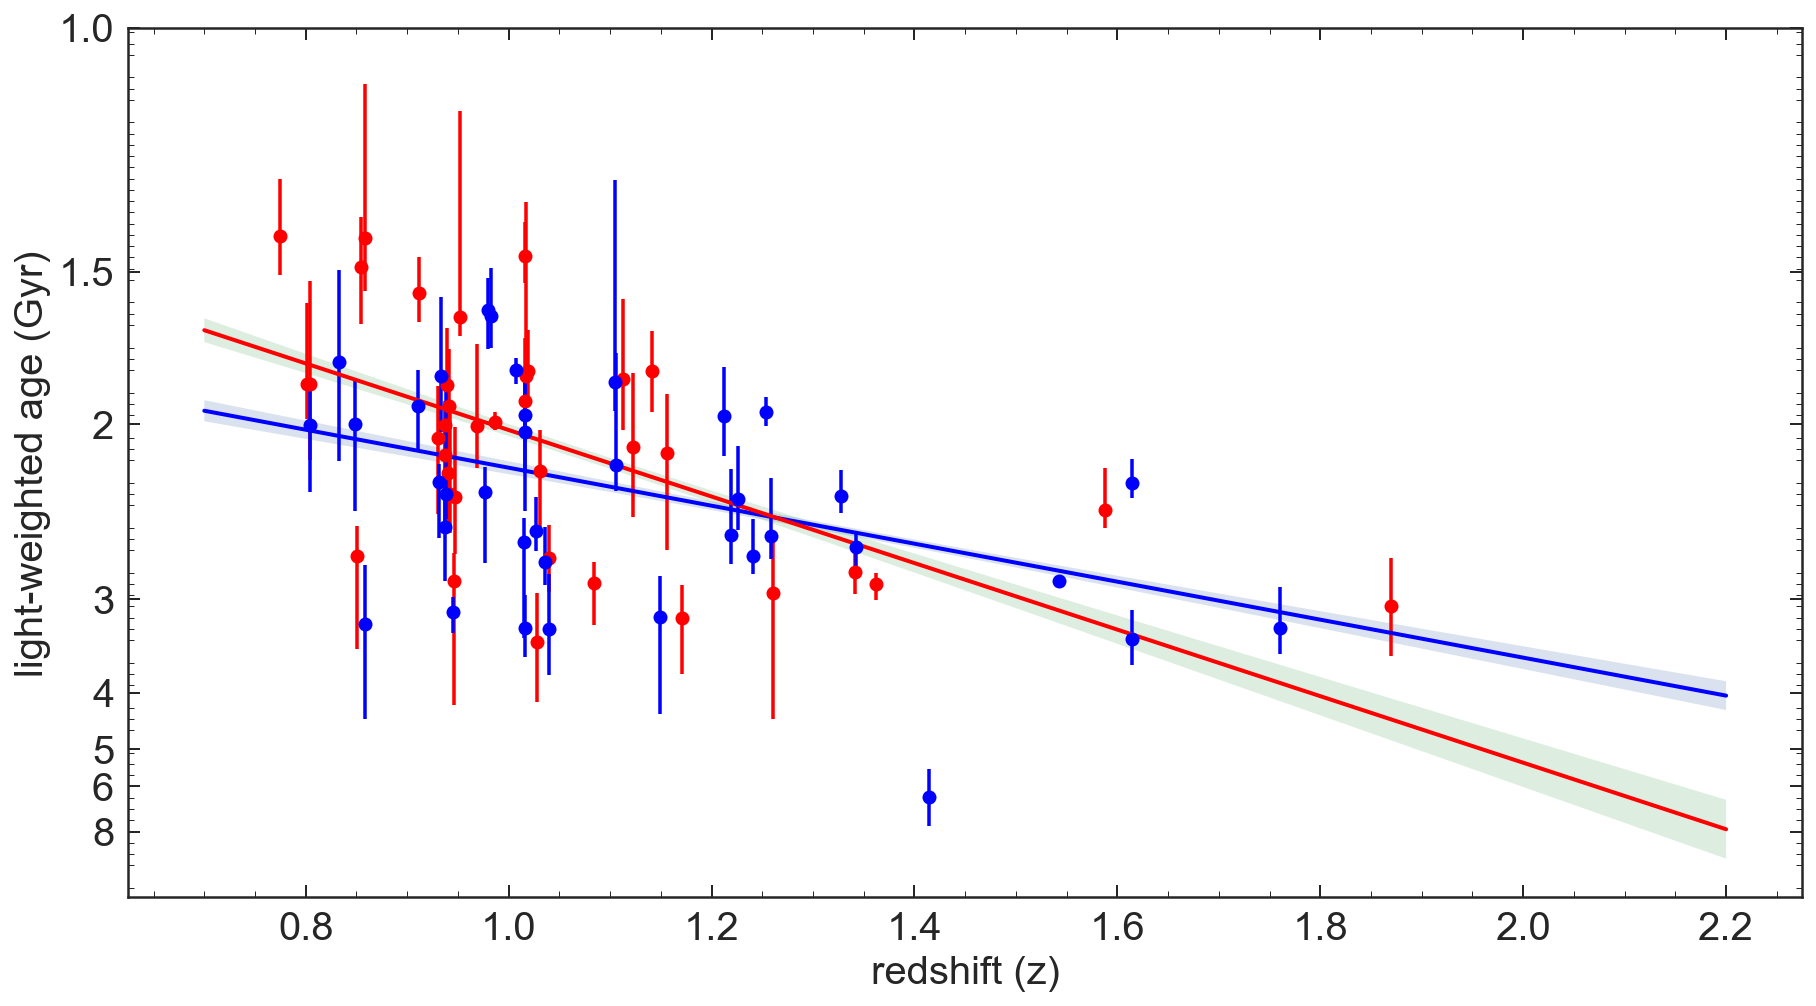

In [10]:
plt.figure(figsize=[15,8])

plt.errorbar(rs[IDE],Oldest_galaxy(rs[IDE]) - lwa[IDE], yerr=[lwal[IDE],lwah[IDE]], fmt='o', color = 'r')

plt.errorbar(rs[IDC],Oldest_galaxy(rs[IDC]) - lwa[IDC], yerr=[lwal[IDC],lwah[IDC]], fmt='o', color = 'b')

redshifts = np.arange(0.7, 2.2, 0.1)
        
errs = (lwah[IDC] + lwal[IDC])/2
Clfit,Clfit_errs = Linear_fit(rs[IDC],Oldest_galaxy(rs[IDC]) - lwa[IDC],errs,redshifts)   

errs = (lwah[IDE] + lwal[IDE])/2
Elfit,Elfit_errs = Linear_fit(rs[IDE],Oldest_galaxy(rs[IDE]) - lwa[IDE],errs,redshifts)   
        
plt.plot(redshifts,Clfit,'b',linewidth=2,label ='Best Fit Line')
plt.fill_between(redshifts,Clfit - Clfit_errs,Clfit + Clfit_errs,alpha = .2,label = '68% Conifidence Interval')


plt.plot(redshifts,Elfit,'r',linewidth=2,label ='Best Fit Line')
plt.fill_between(redshifts,Elfit - Elfit_errs,Elfit + Elfit_errs,alpha = .2,label = '68% Conifidence Interval')
plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

In [11]:
def Leave_one_out(dist, x):
    Y = np.zeros(x.size)
    for i in range(len(dist)):
        Y += dist[i]
    Y /= np.trapz(Y, x)

    w = np.arange(.01, 2.01, .01)
    weights = np.zeros(len(dist))
    for i in range(len(dist)):
        Ybar = np.zeros(x.size)
        for ii in range(len(dist)):
            if i != ii:
                Ybar += dist[ii]
        Ybar /= np.trapz(Ybar, x)
        weights[i] = np.sum((Ybar - Y) ** 2) ** -1
    return weights

def Stack_posteriors(P_grid, x):
    P_grid = np.array(P_grid)
    W = Leave_one_out(P_grid,x)
    top = np.zeros(P_grid.shape)
    for i in range(W.size):
        top[i] = W[i] * P_grid[i]
    P =sum(top)/sum(W)
    return P / np.trapz(P,x)

def Iterative_stacking(grid_o,x_o, extend=False, iterations = 20,resampling = 250):
    ksmooth = importr('KernSmooth')
    del_x = x_o[1] - x_o[0]
    rto = int(np.abs(min(np.log10(x_o)[np.abs(np.log10(x_o)) != np.inf])))+1

    if extend:
        x_n,grid_n = Reconfigure_dist(grid_o,x_o,rto)

        x = np.linspace(x_n[0],x_n[-1],resampling)
        grid = np.zeros([len(grid_n),x.size])    
        for i in range(len(grid_n)):
            grid[i] = interp1d(x_n,grid_n[i])(x)
        ### select bandwidth
        H = ksmooth.dpik(x_o) 
    else:
        x = np.linspace(x_o[0],x_o[-1],resampling)
        grid = np.zeros([len(grid_o),x.size])    
        for i in range(len(grid_o)):
            grid[i] = interp1d(x_o,grid_o[i],fill_value=0, bounds_error=False)(x)

        ### select bandwidth
        H = ksmooth.dpik(x)
    ### stack posteriors w/ weights
    stkpos = Stack_posteriors(grid,x)
    ### initialize prior as flat
    Fx = np.ones(stkpos.size)
    
    for i in range(iterations):
        fnew = Fx * stkpos / np.trapz(Fx * stkpos,x)
        fx = ksmooth.locpoly(x,fnew,bandwidth = H)
        X = np.array(fx[0])
        iFX = np.array(fx[1])
        Fx = interp1d(X,iFX)(x)

    Fx[Fx<0]=0
    rsFx = interp1d(x,Fx)(x_o)
    rsFx = rsFx/np.trapz(rsFx,x_o)  
    
    rsstkpos = interp1d(x,stkpos)(x_o)
    rsstkpos = rsstkpos/np.trapz(rsstkpos,x_o)  
    return rsFx,rsstkpos

In [12]:
def Gen_grid_lwa(INDEXS):
    grid=[]
    all_age = np.arange(0,7 + 0.01,0.01)
    
    for i in INDEXS:
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(select.field[i],select.id[i]))
        z,pz = np.load('../data/posteriors/{0}_{1}_tabfit_Pz.npy'.format(select.field[i],select.id[i]))

        grid.append(interp1d(Oldest_galaxy(z[pz == max(pz)][0]) - x,px, fill_value=0, bounds_error=False)(all_age))
    return np.array(grid)

def Gen_grid(INDEXS, param):
    all_age = np.arange(0,7 + 0.01,0.01)
    grid = np.zeros([len(INDEXS), len(all_age)])

    for i in range(len(INDEXS)):
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_P{2}.npy'.format(select.field[INDEXS[i]],select.id[INDEXS[i]], param))
        grid[i] = interp1d(x,px, fill_value=0, bounds_error=False)(all_age)
    return grid

all_age = np.arange(0,7 + 0.01,0.01)

P_C = Gen_grid_lwa(IDXC)
P_E = Gen_grid_lwa(IDXE)

PE,PEx = Iterative_stacking(P_E,all_age)
PC,PCx = Iterative_stacking(P_C,all_age)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


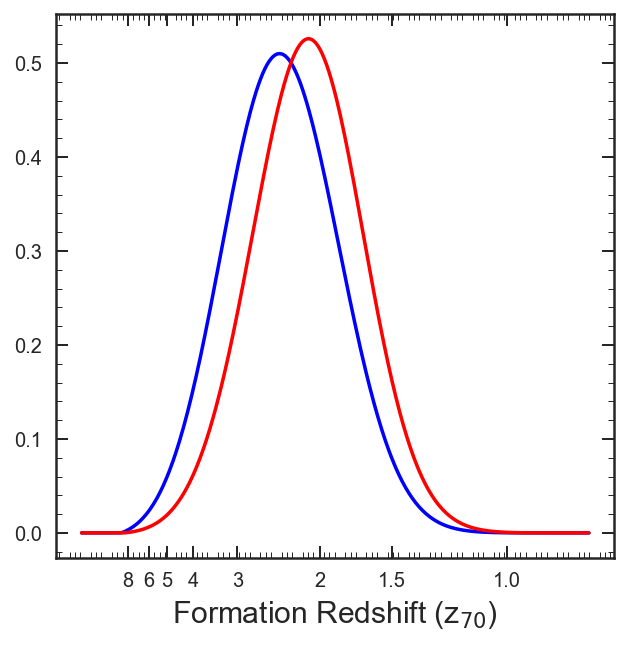

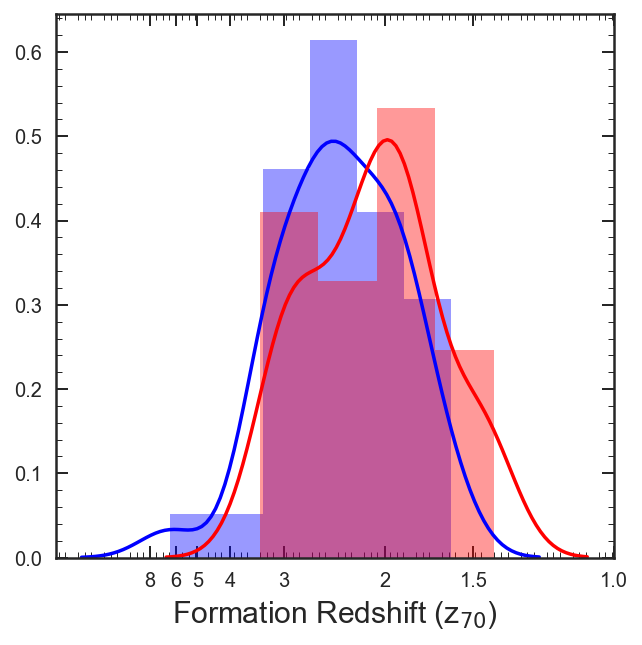

In [17]:
plt.figure(figsize=[5,5])
plt.plot(all_age, PC, 'b')
plt.plot(all_age, PE,'r')
plt.xticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.xlabel('Formation Redshift (z$_{70}$)',size=15)
plt.savefig('../plots/com_exp_stack.png' ,bbox_inches = 'tight')

plt.figure(figsize=[5,5])
sea.distplot((Oldest_galaxy(rs) - lwa)[IDC], color = 'b')
sea.distplot((Oldest_galaxy(rs) - lwa)[IDE], color = 'r')
plt.xticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])
plt.xlabel('Formation Redshift (z$_{70}$)',size=15)
plt.savefig('../plots/com_exp_hist.png' ,bbox_inches = 'tight')


/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in log10


skip
skip
skip


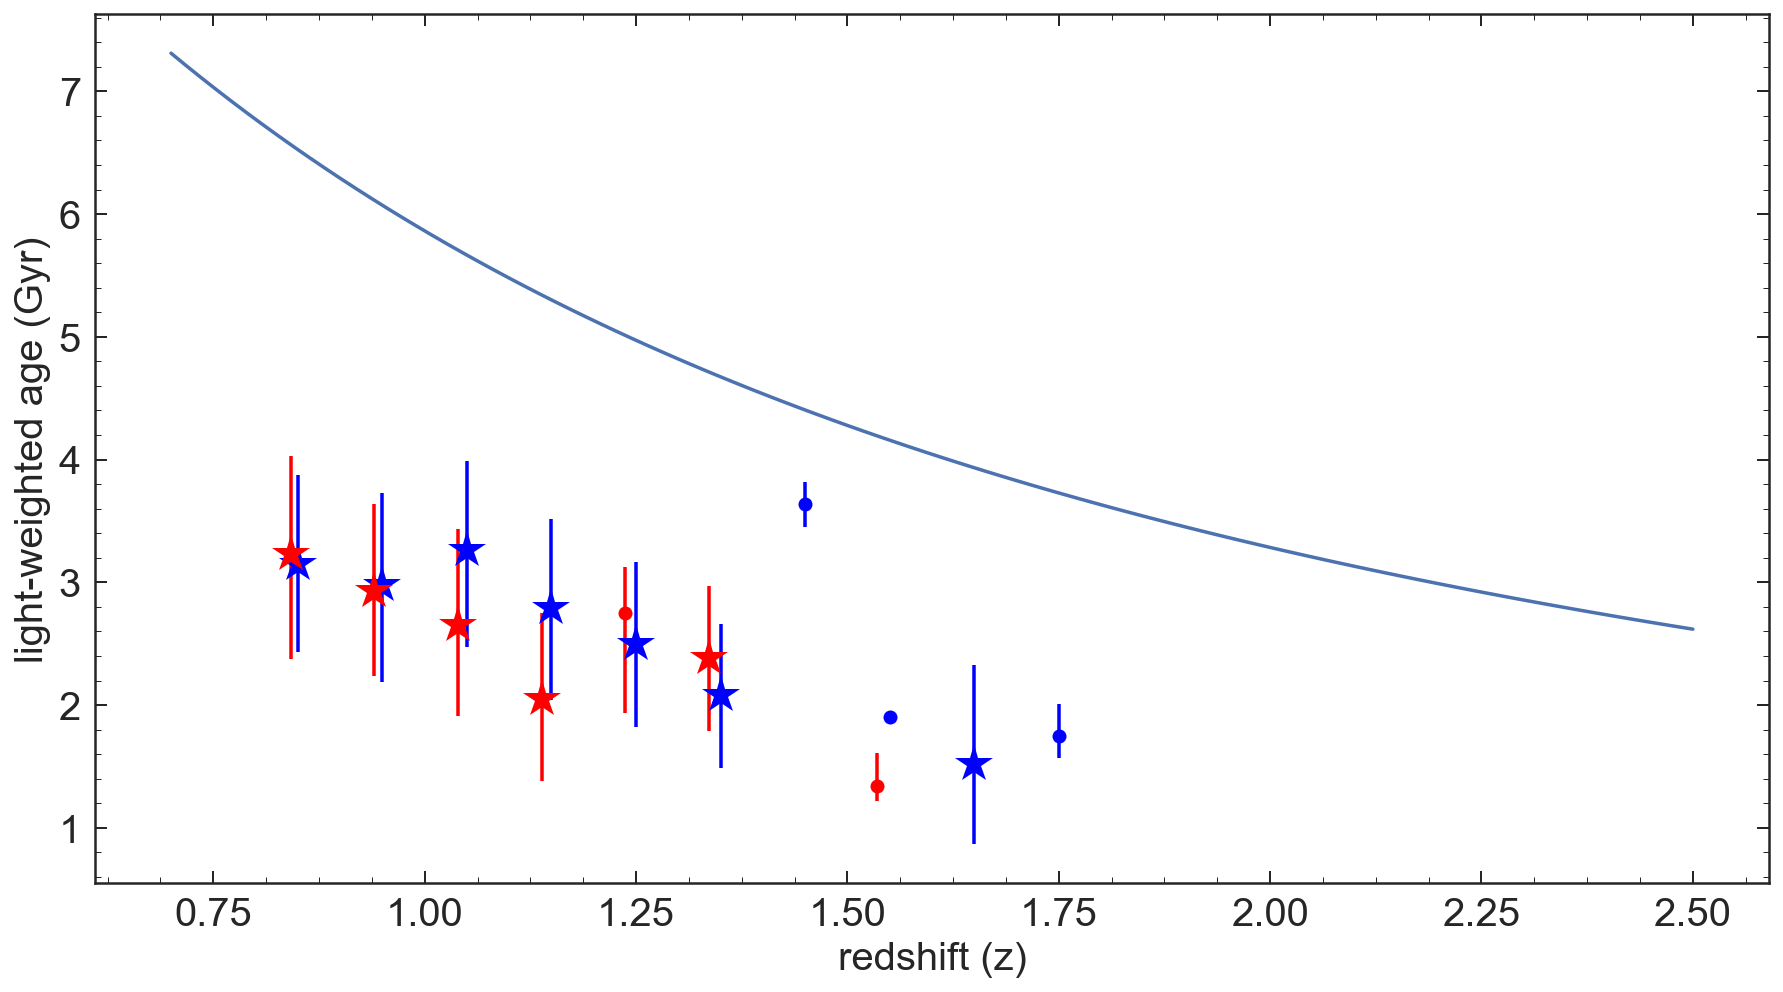

In [22]:
z=np.linspace(0.7,2.5,100)
ages=[Oldest_galaxy(a) for a in z]

plt.figure(figsize=[15,8])

plt.plot(z,ages)

zranges = np.arange(0.8, 1.9, 0.1 )

for i in range(len(zranges)-1):
    IDm = []
    for ii in range(len(IDC)):
        if zranges[i] <= rs[IDC[ii]] <= zranges[i+1]:
            IDm.append(IDXC[ii])
    
    if len(IDm) > 1:
        P_m = Gen_grid(IDm, 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='*', color = 'b', markersize=20)
        
    else:
        x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(select.field[IDm[0]],select.id[IDm[0]]))
        m,ml,mh =Highest_density_region(px,x)
        plt.errorbar((zranges[i] + zranges[i+1])/2, m, yerr=[[ml],[mh]], fmt='o', color = 'b')

###################
    IDm = []
    for ii in range(len(IDE)):
        if zranges[i] <= rs[IDE[ii]] <= zranges[i+1]:
            IDm.append(IDXE[ii])
    
    if len(IDm) > 1:
        P_m = Gen_grid(IDm, 'lwa')
        Pm,Pmx = Iterative_stacking(P_m,all_age)
        m,ml,mh = Highest_density_region(Pm, all_age)
        plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='*', color = 'r', markersize=20)
        
    else:
        try:
            x,px = np.load('../data/posteriors/{0}_{1}_tabfit_Plwa.npy'.format(select.field[IDm[0]],select.id[IDm[0]]))
            m,ml,mh =Highest_density_region(px,x)
            plt.errorbar((zranges[i] + zranges[i+1])/2 * 0.99, m, yerr=[[ml],[mh]], fmt='o', color = 'r')
        
        except:
            print('skip')
        
# for i in zranges:
#     plt.axvline(i)
        
plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
plt.savefig('../plots/com_exp_lwa.png' ,bbox_inches = 'tight')


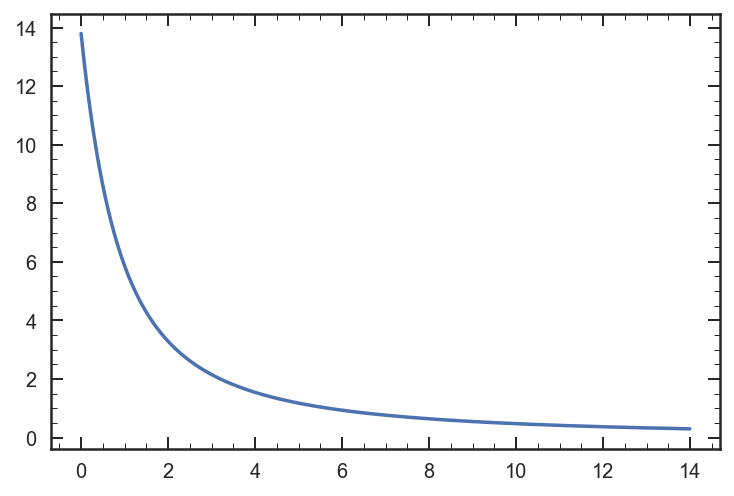

In [121]:
plt.plot(rshifts, age_at_z)

In [157]:
E_z_q = []
E_z_50 = []
E_ssfr = []
C_z_q = []
C_z_50 = []
C_ssfr = []

for i in IDXE:
    SFH = Rescale_sfh(select.field[i], select.id[i])
    E_z_q.append(SFH.z_q)
    E_z_50.append(SFH.z_50)
    E_ssfr.append(SFH.ssfr)
    
    
for i in IDXC:
    SFH = Rescale_sfh(select.field[i], select.id[i])
    C_z_q.append(SFH.z_q)
    C_z_50.append(SFH.z_50)
    C_ssfr.append(SFH.ssfr)
    

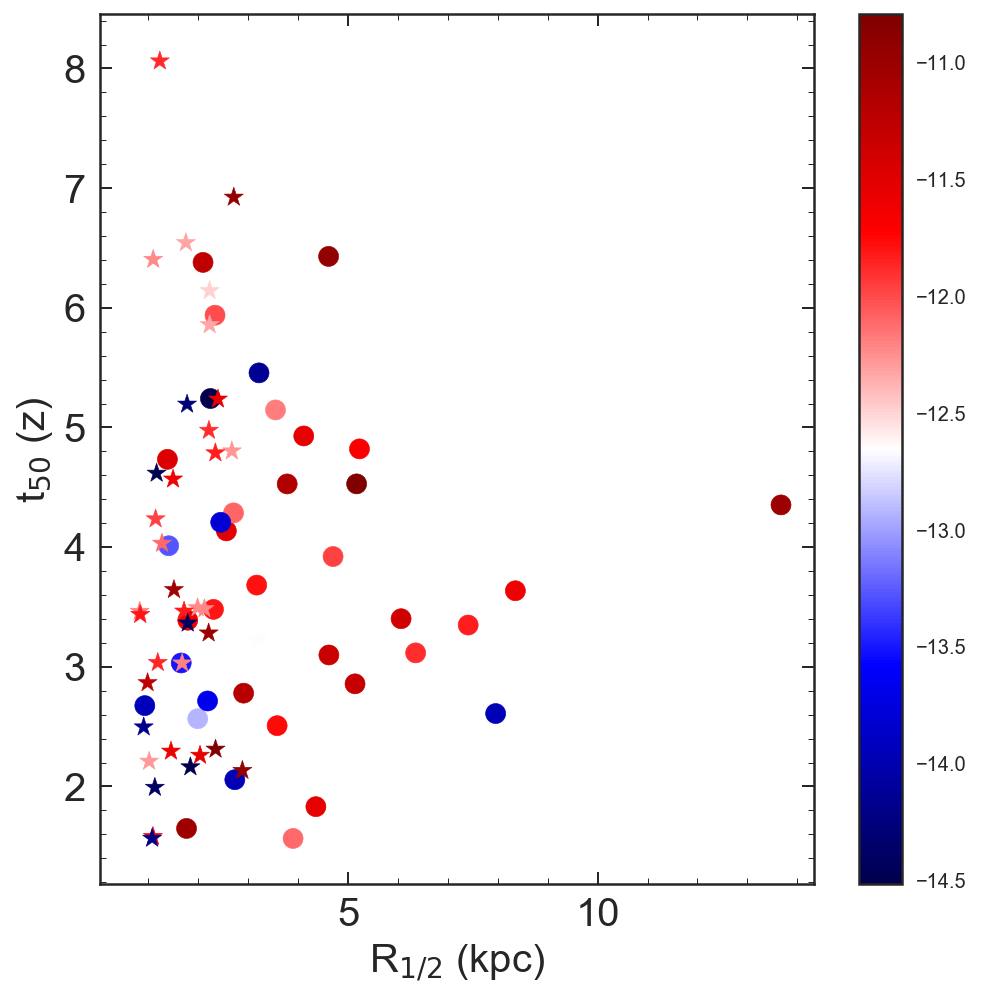

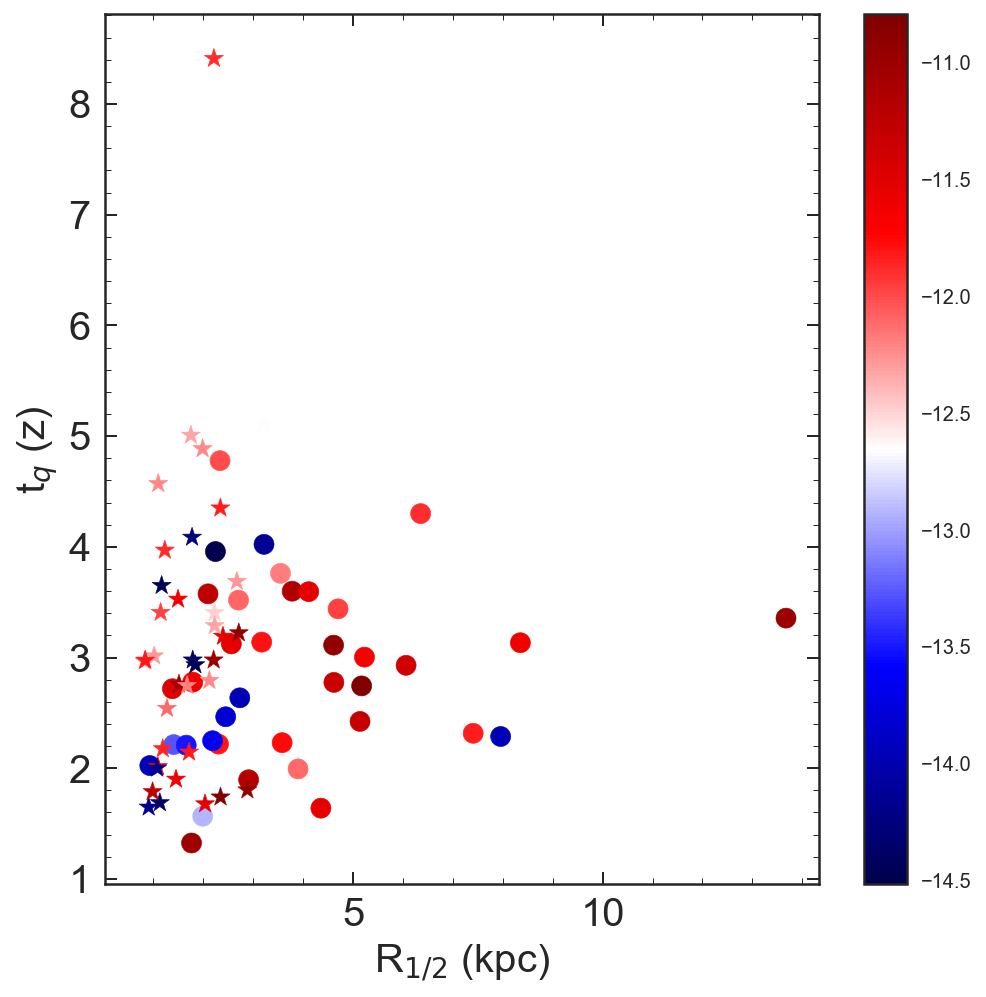

In [176]:
plt.figure(figsize=[8,8])

plt.scatter(Rpc[IDE],E_z_50, marker='o', c = np.log10(E_ssfr), s =100 , cmap='seismic' )
plt.scatter(Rpc[IDC],C_z_50, marker='*', c = np.log10(C_ssfr), s =100 , cmap='seismic')

plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('t$_{50}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.xlim(0,12)
# plt.ylim(2.0,5.0)
plt.savefig('../plots/t50_R.png' ,bbox_inches = 'tight')

plt.figure(figsize=[8,8])

plt.scatter(Rpc[IDE],E_z_q, marker='o', c = np.log10(E_ssfr), s =100 , cmap='seismic')
plt.scatter(Rpc[IDC],C_z_q, marker='*', c = np.log10(C_ssfr), s =100 , cmap='seismic')

plt.colorbar()

plt.xlabel('R$_{1/2}$ (kpc)', fontsize=20)
plt.ylabel('t$_{q}$ (z)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.xlim(0,12)
# plt.ylim(2.0,5.0)
plt.savefig('../plots/tq_R.png' ,bbox_inches = 'tight')


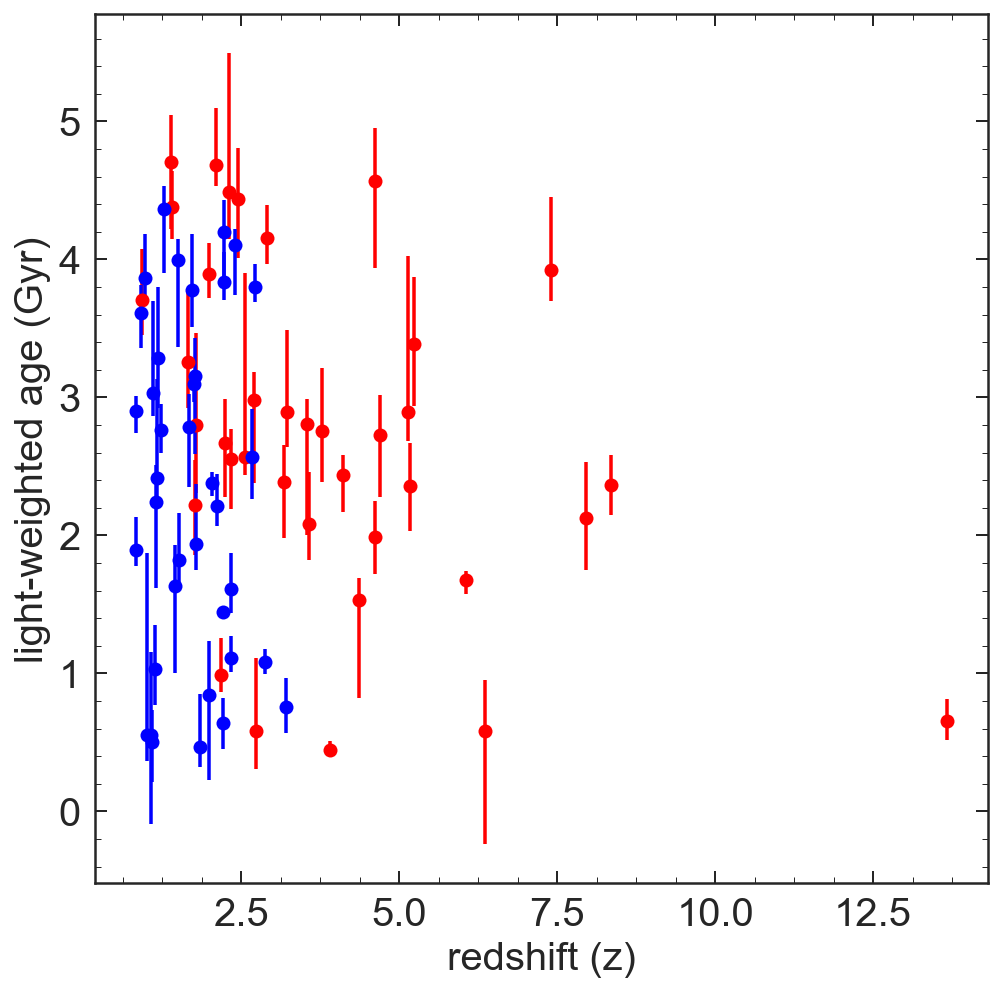

In [108]:
plt.figure(figsize=[8,8])

plt.errorbar(Rpc[IDE],E_z_q, yerr=[lwal[IDE], lwah[IDE]], fmt='o', color = 'r')
plt.errorbar(Rpc[IDC],C_t_q, yerr=[lwal[IDC], lwah[IDC]], fmt='o', color = 'b')

plt.xlabel('redshift (z)', fontsize=20)
plt.ylabel('light-weighted age (Gyr)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)
# plt.yticks([0.6389,0.9315,1.1735,1.5413,2.1489,3.2845,4.278,5.863],[8,6,5,4,3,2,1.5,1.0])


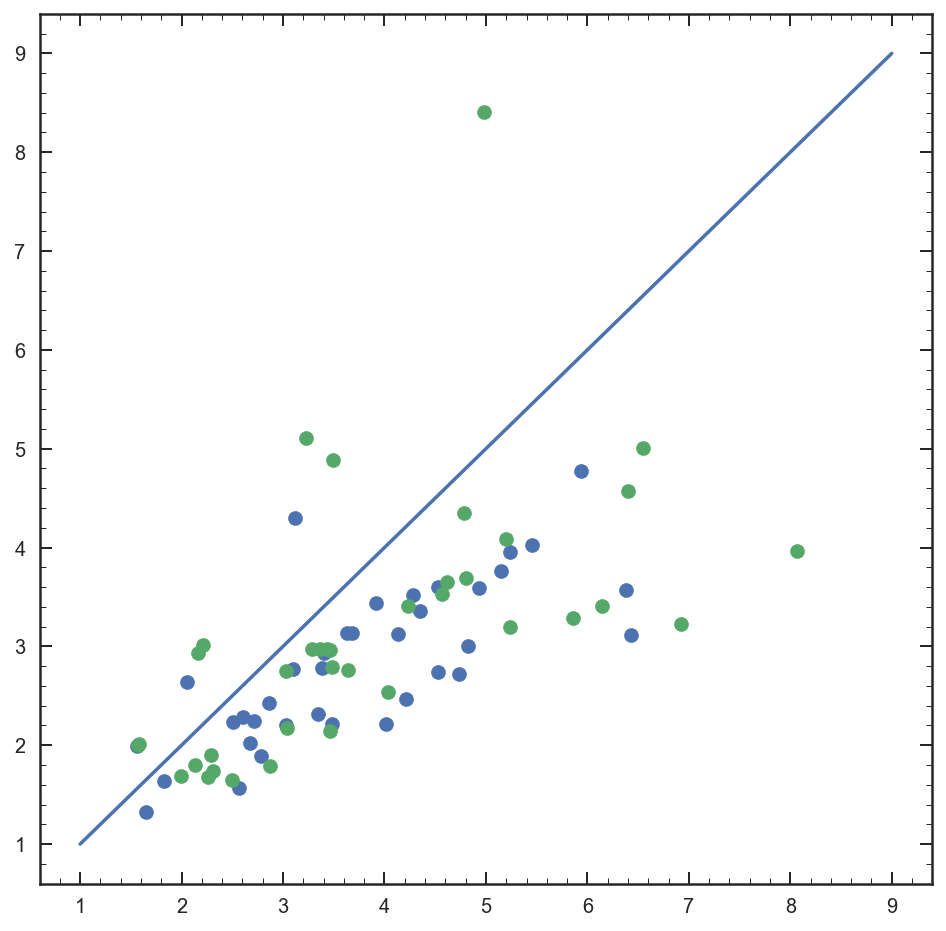

In [162]:
plt.figure(figsize=[8,8])
plt.scatter(E_z_50, E_z_q)
plt.scatter(C_z_50, C_z_q)
plt.plot([1,9],[1,9])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


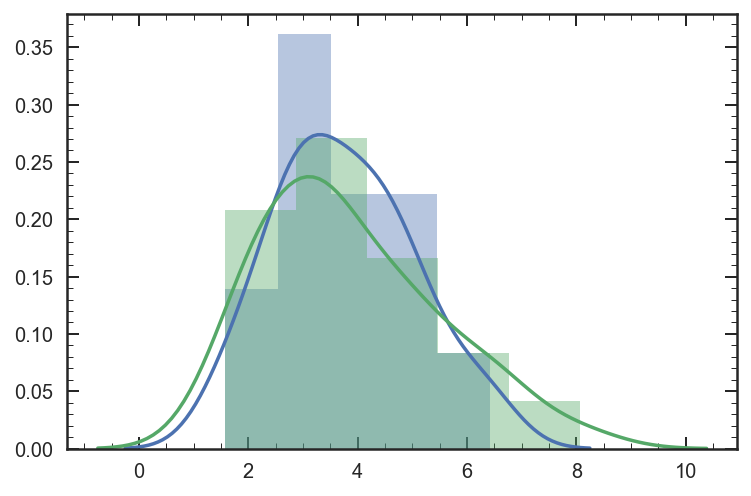

In [174]:
sea.distplot(E_z_50)
sea.distplot(C_z_50)

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


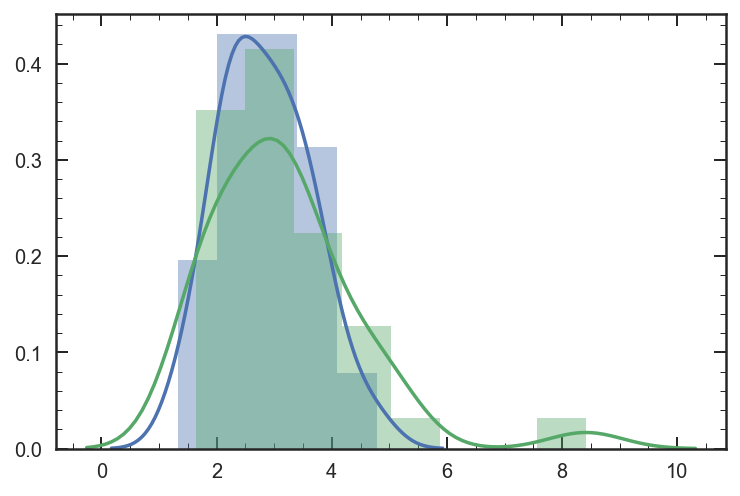

In [175]:
sea.distplot(E_z_q)
sea.distplot(C_z_q)